In [246]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

In [180]:
data_genre = np.loadtxt('item.txt', encoding='latin-1', delimiter='|', dtype=str)
data_genre = data_genre[:, [1]+ list(range(5, 24))]

In [181]:
np.shape(data_genre)

data_X_genre = np.zeros([np.shape(data_genre)[0], 2])
for i in range(np.shape(data_genre)[0]):
    indices_with_ones = np.where(data_genre[i] == '1')[0]
    random_genre = np.random.choice(indices_with_ones)
    data_X_genre[i] = [int(random_genre),int(i+1)]

In [182]:
genres = np.loadtxt('genre.txt', encoding='latin-1', delimiter='|', dtype=str)


data_X_genre=data_X_genre[data_X_genre[:, 0].argsort()].astype(int)
print(data_X_genre)

[[   1  267]
 [   1 1373]
 [   2  449]
 ...
 [  19 1455]
 [  19  922]
 [  19 1247]]


In [183]:
# [ User ID, Movie ID, Rating]
data_movies = np.loadtxt('data.txt', encoding='latin-1', delimiter='	', dtype=str)
data_movies = data_movies[:, [0,1,2]].astype(int)
data_movies = data_movies[data_movies[:, 0].argsort()].astype(int)

print(data_movies)

[[  1  55   5]
 [  1 203   4]
 [  1 183   5]
 ...
 [943 284   2]
 [943  62   3]
 [943 210   4]]


In [416]:
data_people = np.loadtxt('u_user.txt', encoding='latin-1', delimiter='|', dtype=str)
data_people = data_people[:, [0]+ [2]]

# nx2 matrix where [Person ID; 0 for male and 1 for female]
data_people[:, 1] = np.where(data_people[:, 1] == 'M', 0, 1)
data_people = data_people.astype(int)

X_matrix = np.zeros([np.shape(data_people)[0]+1, np.shape(data_genre)[0]+1])

for i in range(np.shape(data_movies)[0]):
    X_matrix[data_movies[i][0],data_movies[i][1]] = data_movies[i][2]

for i in range(np.shape(data_X_genre)[0]):
    X_matrix[0, data_X_genre[i][1]] = data_X_genre[i][0]

sorted_indices = np.argsort(X_matrix[0])
X_matrix = X_matrix[:, sorted_indices]


data_people = np.vstack(([0,0],data_people))
X_matrix = np.hstack((X_matrix,data_people))

first_row = X_matrix[0, :]
shuffled = X_matrix[1:,:]
np.random.shuffle(shuffled) # also need to shuffle labels together

X_matrix = np.vstack([first_row, shuffled])


genre_labels = X_matrix[0][1:np.shape(data_genre)[0]+1].astype(int)

X_matr = (X_matrix.copy())[1:,1:np.shape(data_genre)[0]+1]
print(np.shape(X_matr))

# Matrix imputation step
# imp = SimpleImputer(missing_values=0, strategy="median")
# imp.fit(X_matr)
# # X_matr = imp.transform(X_matr)

train_X = X_matr[0:754,1:np.shape(data_genre)[0]+1]
test_X = X_matr[755:,1:np.shape(data_genre)[0]+1]

arr = np.zeros(1682)

for i in range(np.shape(train_X)[0]):
    for j in (np.nonzero(train_X[i])):
        arr[j] += 1


print(train_X)

train_y = (X_matrix[1:755,np.shape(data_genre)[0]+2]).reshape(1,754)
test_y = (X_matrix[756:,np.shape(data_genre)[0]+2]).reshape(1,188)

(943, 1682)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [378]:
print(np.shape(train_X))
print(np.shape(train_y))
print(np.shape(genres))
print(np.shape(genre_labels))

(754, 1681)
(1, 754)
(19,)
(1682,)


In [379]:
grp_dict = {}
grp_dict_indx = {}

for i in range(np.shape(genres)[0]):
    i += 1
    grp_dict[i] = np.count_nonzero(genre_labels == i)
    grp_dict_indx[i] = np.argwhere(genre_labels == i)

In [380]:
def prox_grplasso(b,b_list,lmbda,t,n,k):
    m = np.shape(train_X)[0]
    grad_g = -1 * train_y @ train_X + (1/(1 + np.exp(-train_X @ b).flatten())) @ train_X
   
    # Compute b - t * grad g
    b = b - t * np.transpose(grad_g)
    
    bst = np.zeros(n).reshape(-1,1)
    start = 0
    end = 0

    norms = []
    
    for i in range(1,20):
        if i == 1:
            start = 0
        else:
            start += grp_dict[i-1]
        end = start + grp_dict[i]
        
        norms.append(np.linalg.norm(b[start:end]))
        
        bst[start:end] = np.maximum(0,(1 - (np.sqrt(grp_dict[i])*t*lmbda/np.linalg.norm(b[start:end]))))*b[start:end]   
    
    Xb = train_X @ bst
    
    gb = -1*train_y @ Xb + np.sum(np.log(1 + np.exp(Xb)))
    
    grp_pnlty = 0
    for i in range(1,20):
        grp_pnlty += np.sqrt(grp_dict[i]) * norms[i-1]
    
    hb = lmbda * grp_pnlty
    f = gb + hb

    return [bst, f]

/var/folders/m_/zcc406bs79n86qzh6km17_dm0000gn/T/ipykernel_65935/2100756376.py:27: RuntimeWarning: overflow encountered in exp
  gb = -1*train_y @ Xb + np.sum(np.log(1 + np.exp(Xb)))


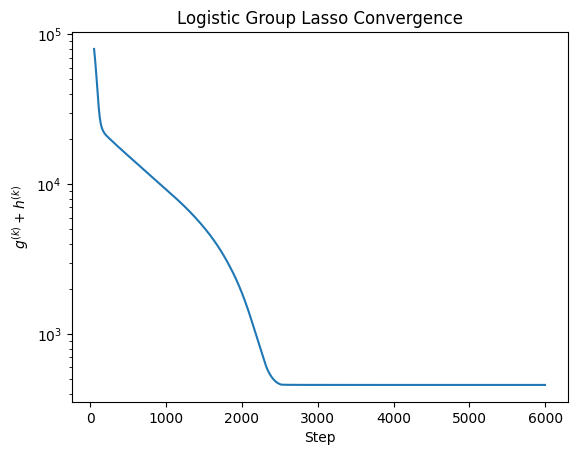

In [414]:
n = np.shape(train_X)[1]
m = np.shape(train_X)[0]

b = np.random.rand(np.shape(train_X)[1]).reshape(-1,1)
b_list = [b]

t = 10e-6

lmbda = 30

f_vals = []
for i in range(6000):
    [b,f] = prox_grplasso(b,b_list,lmbda,t,n,k=-1)
    f_vals.append(f[0])

plt.semilogy(np.arange(6000), f_vals)

plt.xlabel('Step')
plt.ylabel('$g^{(k)}+h^{(k)}$')
plt.title('Logistic Group Lasso Convergence')
plt.show()

In [421]:
print("Objective value:", f_vals[5999])

test_predict = test_X @ b
classify = (np.sign(test_predict - 0.5) + 1)//2
err = np.count_nonzero(classify.flatten() - test_y.flatten())/(np.shape(test_y)[1])

print("Test Classification Error: ", err)

select = np.nonzero(b)[0]
grp_list = []

print("Most Important Movie Genres:")
for j in range(np.shape(genres)[0]):
    grps = [i for i in select if i in grp_dict_indx[j+1]]
    if grps:
        print(genres[j])

Objective value: [458.6926284]
Test Classification Error:  0.26595744680851063
Most Important Movie Genres:
Action
Musical
Sci-Fi
War
